In [25]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn.exceptions import ConvergenceWarning
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [40]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    6000 non-null   int64  
 1   Age           6000 non-null   float64
 2   Systolic_BP   6000 non-null   float64
 3   Diastolic_BP  6000 non-null   float64
 4   Cholesterol   6000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 234.5 KB
None


In [41]:
print(data.describe())

        Unnamed: 0          Age  Systolic_BP  Diastolic_BP  Cholesterol
count  6000.000000  6000.000000  6000.000000   6000.000000  6000.000000
mean   2999.500000    60.464121   100.694822     90.505547   100.628255
std    1732.195139     8.564392    10.669267      9.648200    10.433915
min       0.000000    35.164761    69.675429     62.807105    69.967453
25%    1499.750000    54.371941    93.267420     83.641788    93.202373
50%    2999.500000    59.831159   100.119926     89.912429   100.060637
75%    4499.250000    65.809652   107.439501     96.682405   107.250829
max    5999.000000   103.279497   151.699660    133.456382   148.233544


In [47]:
print(data.isnull().sum())

Unnamed: 0      0
Age             0
Systolic_BP     0
Diastolic_BP    0
Cholesterol     0
dtype: int64


In [44]:
print(data.isnull().sum())

Unnamed: 0      0
Age             0
Systolic_BP     0
Diastolic_BP    0
Cholesterol     0
dtype: int64


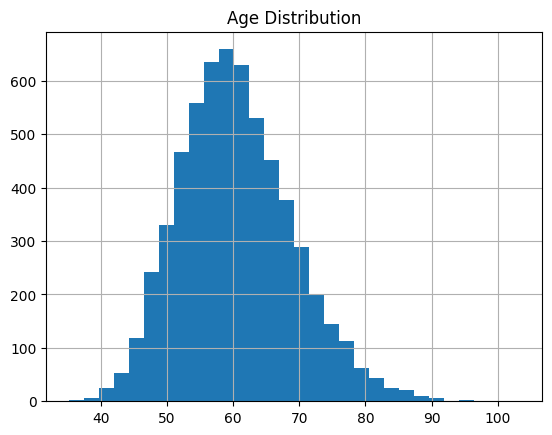

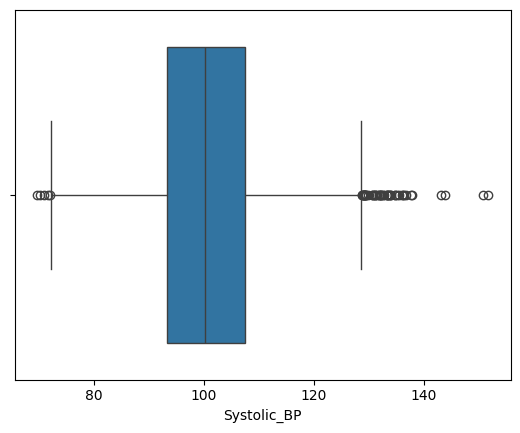

In [68]:
data['Age'].hist(bins=30)
plt.title('Age Distribution')
plt.show()

sns.boxplot(x=data['Systolic_BP']);

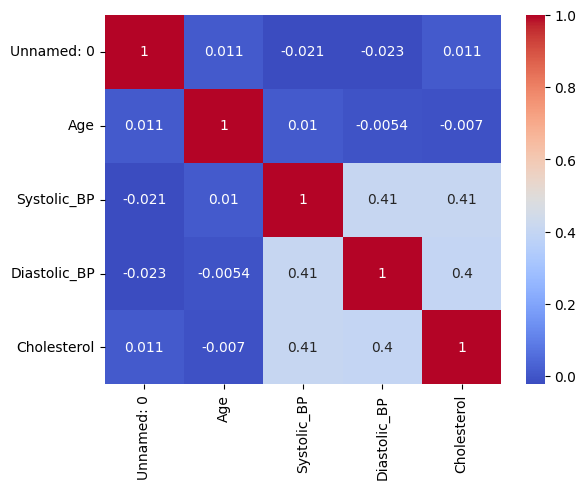

In [69]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

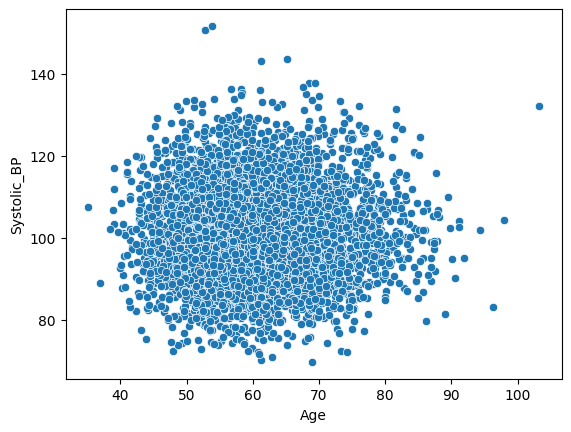

In [70]:
sns.scatterplot(x=data['Age'], y=data['Systolic_BP']);

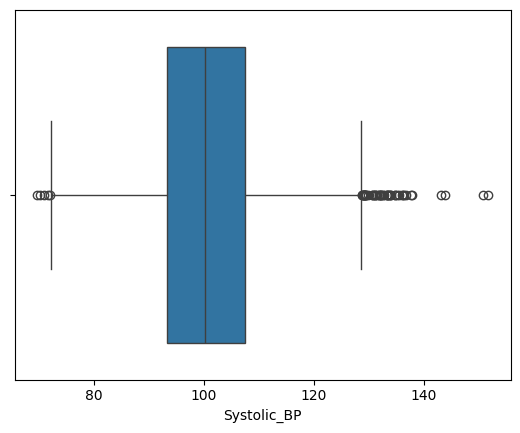

In [71]:
sns.boxplot(x=data['Systolic_BP']);

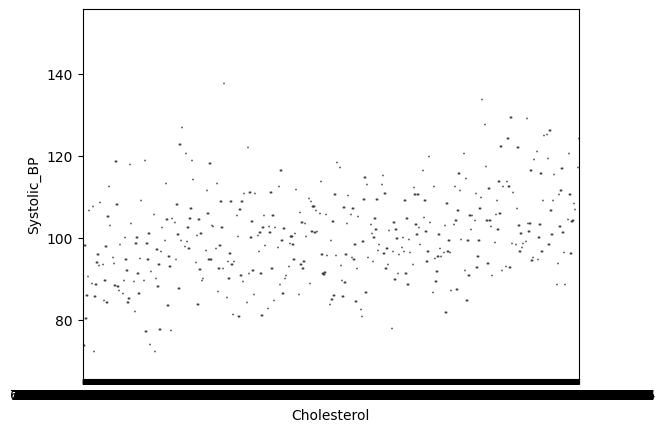

In [72]:
sns.boxplot(x=data['Cholesterol'], y=data['Systolic_BP']);

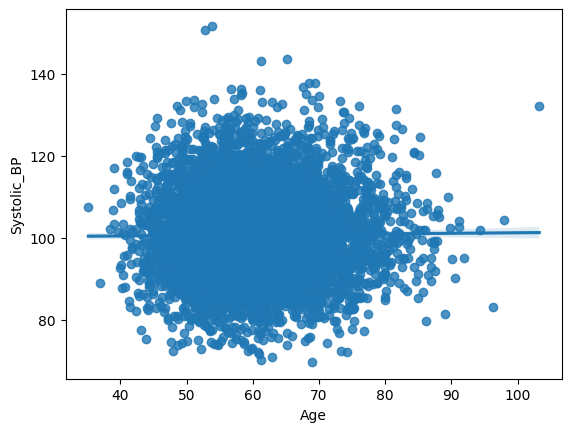

In [73]:
sns.regplot(x=data['Age'], y=data['Systolic_BP']);

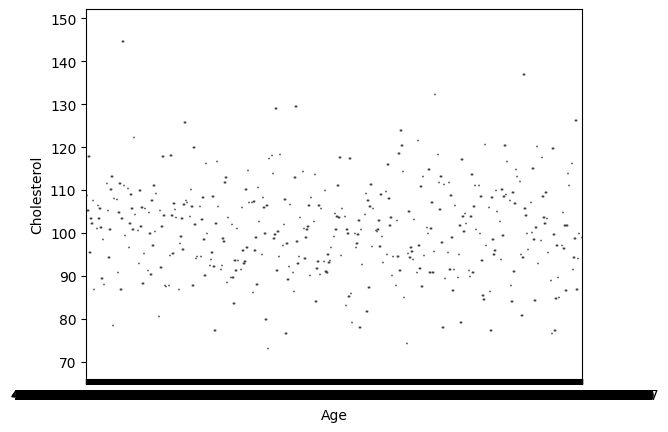

In [74]:
sns.boxplot(x=data['Age'], y=data['Cholesterol']);

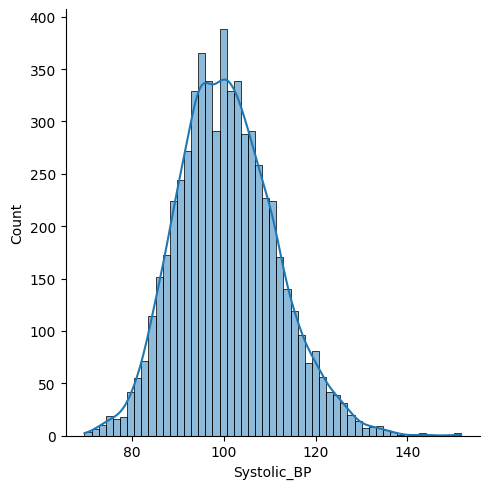

In [75]:
sns.displot(data['Systolic_BP'], kde=True);

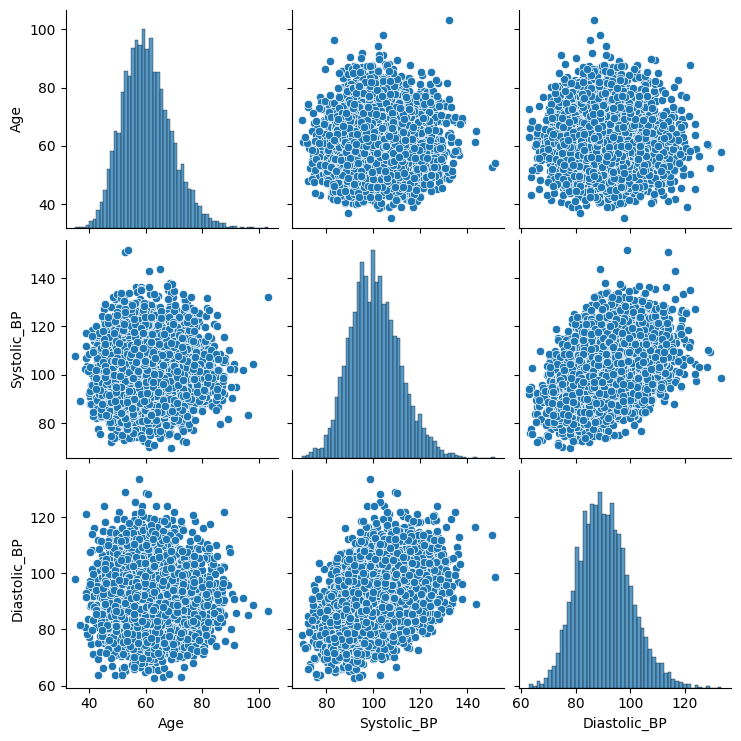

In [76]:
sns.pairplot(data[['Age', 'Systolic_BP', 'Diastolic_BP']]);

In [ ]:
# Load data
data = pd.read_csv('X_data.csv')
X = data.iloc[:, 1:].values

# 1. Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# 2. Apply Kernel PCA with multiple gamma values
def apply_kernel_pca(X, gammas):
    results = {}
    for gamma in gammas:
        kernel_pca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
        X_kpca = kernel_pca.fit_transform(X)
        results[gamma] = X_kpca
    return results

gamma_values = [0.01, 0.1, 1, 10]
kpca_results = apply_kernel_pca(X_scaled, gamma_values)

In [31]:
# 3. Automatic selection of optimal clusters using BIC/AIC
def find_best_gmm(X, covariance_types, max_clusters):
    best_gmm = None
    best_bic = np.inf
    best_params = {}

    for cov_type in covariance_types:
        for n_clusters in range(2, max_clusters + 1):
            gmm = GaussianMixture(
                n_components=n_clusters, 
                covariance_type=cov_type, 
                max_iter=2000, 
                tol=1e-4, 
                reg_covar=1e-6,
                random_state=42
            )
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning)
                    gmm.fit(X)
                bic = gmm.bic(X)
                if bic < best_bic:
                    best_bic = bic
                    best_gmm = gmm
                    best_params = {'n_components': n_clusters, 'covariance_type': cov_type}
            except ValueError as e:
                print(f"Error fitting GMM: {e}")
                continue
    return best_gmm, best_params

# Select gamma with best silhouette score
def evaluate_kpca_results(kpca_results):
    best_score = -1
    best_gamma = None
    best_X_kpca = None

    for gamma, X_kpca in kpca_results.items():
        gmm, params = find_best_gmm(X_kpca, ['full', 'tied', 'diag', 'spherical'], 5)
        if gmm is not None:
            labels = gmm.predict(X_kpca)
            score = silhouette_score(X_kpca, labels)
            if score > best_score:
                best_score = score
                best_gamma = gamma
                best_X_kpca = X_kpca

    return best_gamma, best_X_kpca

best_gamma, X_kpca = evaluate_kpca_results(kpca_results)

In [32]:
# 4. Outlier removal with Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_kpca)
X_filtered = X_kpca[outlier_labels == 1]

# Refit GMM on filtered data
gmm, best_params = find_best_gmm(X_filtered, ['full', 'tied', 'diag', 'spherical'], 5)
best_labels = gmm.predict(X_filtered)

In [33]:
# 5. Visualize with t-SNE (for filtered data)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_filtered)

In [34]:
# 6. Hyperparameter tuning with GridSearchCV (Optional)
param_grid = {
    'n_components': range(2, 6),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-3, 1e-4],
    'reg_covar': [1e-6, 1e-4]
}

best_gmm = None
best_params = None
best_score = -1

# Perform hyperparameter tuning to find the best model
for params in ParameterGrid(param_grid):
    gmm = GaussianMixture(**params, random_state=42)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            gmm.fit(X_filtered)
        labels = gmm.predict(X_filtered)
        score = silhouette_score(X_filtered, labels)
        if score > best_score:
            best_score = score
            best_gmm = gmm
            best_params = params
    except ValueError as e:
        print(f"Error in hyperparameter tuning: {e}")
        continue

# Evaluate additional metrics
best_labels = best_gmm.predict(X_filtered)
silhouette = silhouette_score(X_filtered, best_labels)
calinski_harabasz = calinski_harabasz_score(X_filtered, best_labels)
davies_bouldin = davies_bouldin_score(X_filtered, best_labels)

print("Best Parameters:", best_params)
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

Best Parameters: {'covariance_type': 'tied', 'n_components': 2, 'reg_covar': 0.0001, 'tol': 0.001}
Silhouette Score: 0.8243968380135394
Calinski-Harabasz Index: 3489.6858578395686
Davies-Bouldin Index: 0.681556396325905


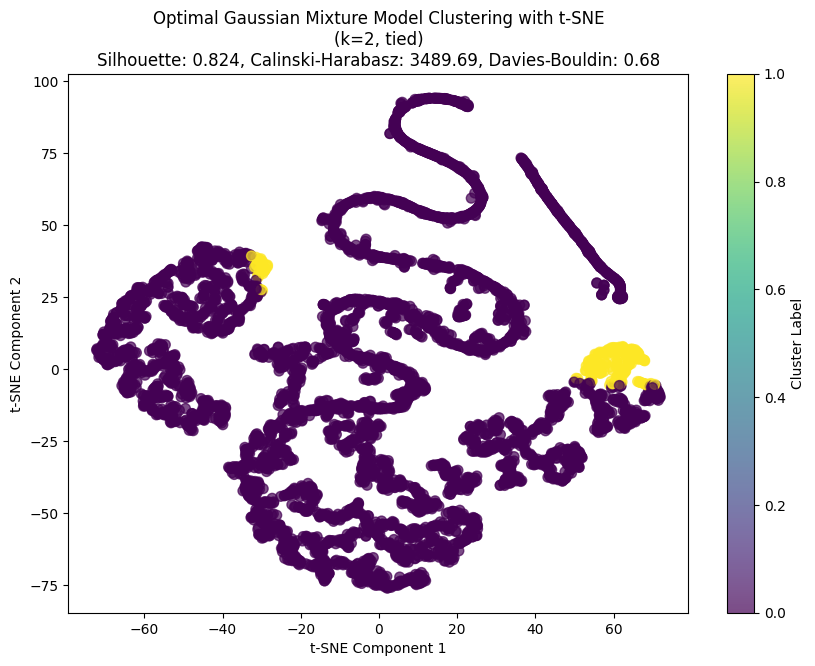

In [35]:
# 7. Visualize clustering result with t-SNE
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(
    f"Optimal Gaussian Mixture Model Clustering with t-SNE\n"
    f"(k={best_params['n_components']}, {best_params['covariance_type']})\n"
    f"Silhouette: {silhouette:.3f}, Calinski-Harabasz: {calinski_harabasz:.2f}, Davies-Bouldin: {davies_bouldin:.2f}"
)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

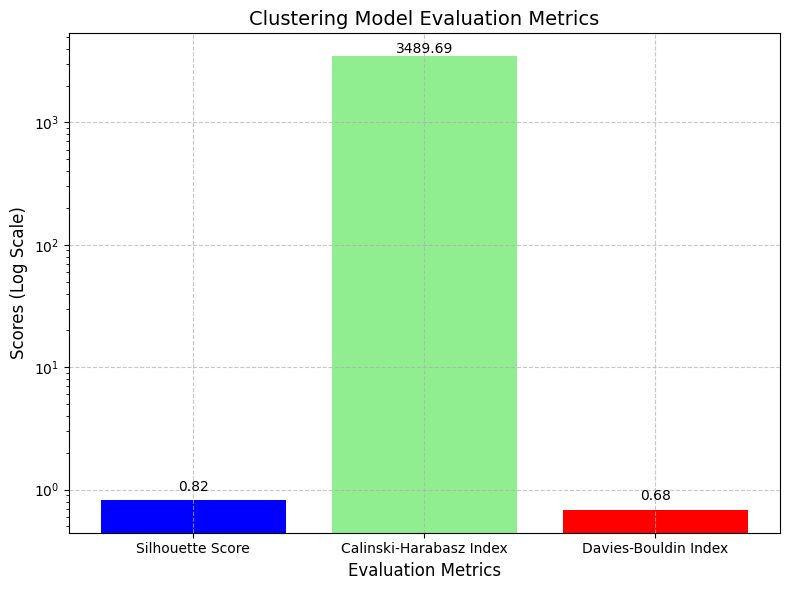

In [36]:
# 8. Visualize metrics
metrics = {
    "Silhouette Score": silhouette,
    "Calinski-Harabasz Index": calinski_harabasz,
    "Davies-Bouldin Index": davies_bouldin
}

fig, ax = plt.subplots(figsize=(8, 6))

labels = list(metrics.keys())
values = list(metrics.values())

ax.bar(labels, values, color=['blue', 'lightgreen', 'red'])
ax.set_yscale('log')  # Set log scale for better visualization

ax.set_title("Clustering Model Evaluation Metrics", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("Evaluation Metrics", fontsize=12)
ax.set_ylabel("Scores (Log Scale)", fontsize=12)

for i, v in enumerate(values):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

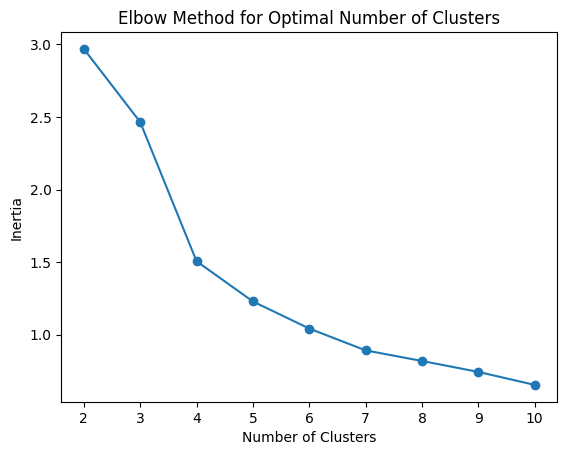

In [37]:
# 9. Elbow Method for Optimal Clusters
inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_filtered)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

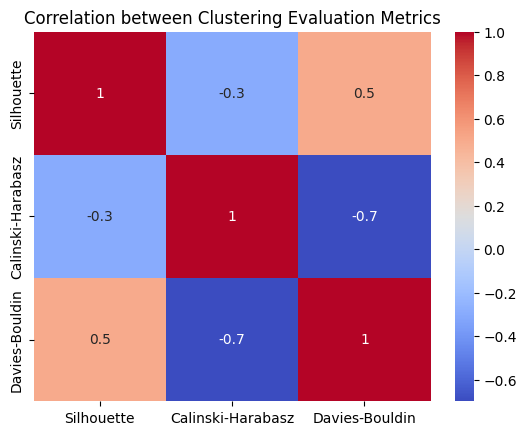

In [38]:
# 10. Heatmap for Correlation of Metrics
metrics_matrix = np.array([
    [1, -0.3, 0.5],
    [-0.3, 1, -0.7],
    [0.5, -0.7, 1]
])

sns.heatmap(metrics_matrix, annot=True, cmap='coolwarm', xticklabels=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'], yticklabels=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
plt.title("Correlation between Clustering Evaluation Metrics")
plt.show()

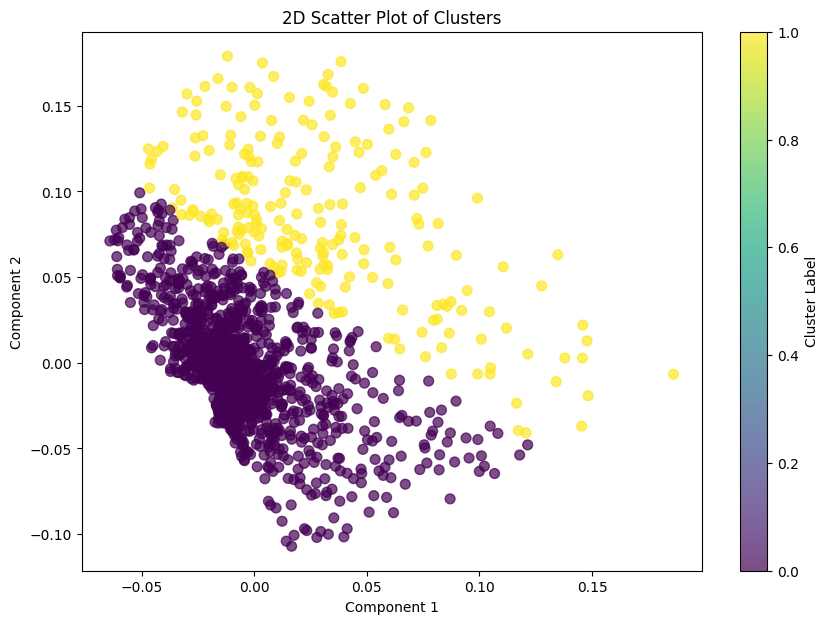

In [39]:
# 11. 2D Visualization of Clusters (Sửa lại vẽ 2D thay vì 3D)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=best_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()